# QUBO's hyper parameter search

This notebook is a simple example of how to use `MINTO` to explore the hyperparameter space of a QUBO model.
For this example, we will handle the Traveling Salesman Problem with quadratic assignment formulation. For more details about the Traveling Salesman Problem, please refer to other resources.

In [1]:
import minto
import matplotlib.pyplot as plt
import jijmodeling as jm

In [2]:
import minto.problems.tsp

tsp = minto.problems.tsp.QuadTSP()
tsp_problem = tsp.problem()

n = 8
tsp_data = tsp.data(n=n)

tsp_problem

In [3]:
interpreter = jm.Interpreter(tsp_data)
instance = interpreter.eval_problem(tsp_problem)

## QUBO formulation

$$
E(x; A) = \sum_{i=0}^{n-1} \sum_{j=0}^{n-1} d_{ij} \sum_{t=0}^{n-1} x_{it} x_{j, (t+1)\mod n} 
+ A \left[
\sum_i \left(\sum_{t} x_{i, t} - 1\right)^2 + \sum_t \left(\sum_{i} x_{i, t} - 1\right)^2
\right]
$$

The parameter $A$ is a hyperparameter that controls the strength of the constraints.

In OMMX, we can tune this parameter using the `.to_qubo(uniform_penalty_weight=...)` method and argument `uniform_penalty_weight` to set the value of $A$.

In [9]:
import ommx_openjij_adapter as oj_ad

parameter_values = [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

experiment = minto.Experiment(auto_saving=False, verbose_logging=False)
for A in parameter_values:
    with experiment.run() as run:
        ox_sampleset = oj_ad.OMMXOpenJijSAAdapter.sample(instance, uniform_penalty_weight=A, num_reads=30)
        run.log_sampleset(ox_sampleset)
        run.log_parameter("A", A)

In [10]:
table = experiment.get_run_table()
table

sampleset_0                                                        \
       num_samples  obj_mean   obj_std   obj_min   obj_max feasible name   
run_id                                                                     
0               30  3.188953  0.357337  2.504148  4.075170        0    0   
1               30  3.433684  0.452678  2.613076  4.111693        1    0   
2               30  4.433708  0.624318  3.073818  5.788542        1    0   
3               30  3.881360  0.676330  2.679128  5.244577        8    0   
4               30  3.260340  0.414716  2.679128  4.173075       25    0   
5               30  3.278696  0.479787  2.679128  4.483248       28    0   
6               30  3.729739  0.748217  2.679128  6.312948       23    0   

       parameter metadata               
               A   run_id elapsed_time  
run_id                                  
0            0.4        0     0.037584  
1            0.5        1     0.030556  
2            0.6        2     0.034105  
3            0.7        3     0.027761  
4            0.8        4     0.030891  
5            0.9        5     0.031988  
6            1.0        6     0.023222

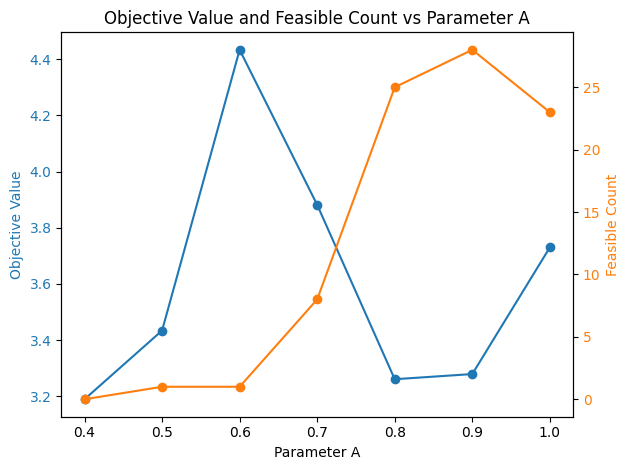

In [11]:
fig, ax1 = plt.subplots()

# First y-axis for objective value
ax1.set_xlabel("Parameter A")
ax1.set_ylabel("Objective Value", color="tab:blue")
ax1.plot(table["parameter"]["A"], table["sampleset_0"]["obj_mean"], "-o", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")

# Second y-axis for feasible count
ax2 = ax1.twinx()
ax2.set_ylabel("Feasible Count", color="tab:orange")
ax2.plot(table["parameter"]["A"], table["sampleset_0"]["feasible"], "-o", color="tab:orange")
ax2.tick_params(axis="y", labelcolor="tab:orange")

plt.title("Objective Value and Feasible Count vs Parameter A")
fig.tight_layout()